# MCM complexes are barriers that restrict cohesin-mediated loop extrusion

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 3
+ S9

#### Archives:
+ Cohesin-MCM_wt_highsalt.yama
+ Cohesin-MCM_wt_lowsalt.yama
+ Cohesin-only_lowsalt.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji_MARS-beta18.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
import scipy.stats
import itertools
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from marspy.stats import bootstrap, calc_ci, significance
from tqdm.notebook import tqdm
from functools import reduce
from scipy.stats import norm
from pingouin import welch_anova, pairwise_gameshowell


marspy initialized.


### Select archives

In [3]:
selected_archives = ['Cohesin-MCM_wt_highsalt.yama',
                     'Cohesin-MCM_wt_lowsalt.yama',
                     'Cohesin-MCM_YDF_lowsalt.yama',
                     'Cohesin-only_lowsalt.yama']

/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

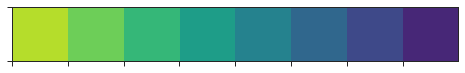

In [6]:
sns.palplot(palette)

In [7]:
# change to desired output directory
dir_out = '/Users/matze/Documents/PhD/Manuscripts/MCM-cohesin_sliding/Figures/SVGs/'
dir_out

'/Users/matze/Documents/PhD/Manuscripts/MCM-cohesin_sliding/Figures/SVGs/'

### Instantiate selected archives

In [8]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

MCM variant not found. Setting default to n/a



### Add df_noidle to all molecules

In [9]:
for archive in tqdm(DnaMoleculeArchive.instances):
    
    archive.add_df_noidle(prefix='Cohesin_1_', specifier='idle')
    

### Archives Overview

In [10]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,NaCl concentration,MCM variant,archive validation
Cohesin-MCM_wt_highsalt,12,106,Halo-JF549-Cohesin; ybbR-LD655-MCM,ATP,500 mM,wt,passed
Cohesin-MCM_wt_lowsalt,20,181,Halo-JF549-Cohesin; ybbR-LD655-MCM,ATP,150 mM,wt,passed
Cohesin-MCM_YDF_lowsalt,20,86,Halo-JF549-Cohesin; ybbR-LD655-MCM,ATP,150 mM,ydf,passed
Cohesin-only_lowsalt,4,59,Halo-JF549-Cohesin,ATP,150 mM,n/a,passed


### Functions

In [150]:
def calc_msd(df, prefix, msd_col, time_col, tau=1, start=np.nan, end=np.nan):
    """
    Calculates mean square displacement of molecules.
    Remove pairs with missing frames in interval, do not drop NaN values!
    *df: dataframe
    *prefix: protein prefix
    *msd_col: column in df to calculate msd (without protein prefix!)
    *time_col: time column in df (without protein prefix!)
    *tau: time delta used to calculate msd (without protein prefix!)
    *ignore_region: provide region name (regex) which is ignored for msd calculation (default False)
    
    returns (msd, dtime)
    msd: mean squared error
    dtime: mean time difference underlying msd calculation
    """
    
    # if not start / end was specified by used, set to max range
    if np.isnan(start):
        #start=df[prefix+time_col].iloc[0]
        start=df[prefix+time_col].min()
        
    if np.isnan(end):
        #end=df[prefix+time_col].iloc[-1]
        end=df[prefix+time_col].max()
        
    # will be a more accurate way to calculate MSD due to existing NaN values
    diffs = []
    dtimes = []
    for row in df.index:
        try:
            # check if sliding window range
            if (df.loc[row, prefix+time_col] >= start and df.loc[row+tau, prefix+time_col] <= end):

                # check if we have consecutive frames (T) which are not null
                if (((df.loc[row+tau, prefix+'T'] - df.loc[row, prefix+'T']) == tau) and not
                    ((np.isnan(df.loc[row+tau, prefix+msd_col]) or np.isnan(df.loc[row, prefix+msd_col])))):

                    diffs.append(df.loc[row+tau, prefix+msd_col] - df.loc[row, prefix+msd_col])
                    dtimes.append(df.loc[row+tau, prefix+time_col] - df.loc[row, prefix+time_col])

                else:
                    #skip to next row
                    continue

        # end of df
        except KeyError:
            break
            
    return np.mean(np.square(diffs)), np.mean(dtimes)

In [151]:
def calc_ars1_encounters(molecule):
    """
    Calculates encounters and encounter outcomes with ARS1 for a molecule object.
    """
    
    #reset to 0 in case it reruns
    #visualized encounters
    molecule.ars1_encounters_vis = 0
    
    #passage events
    molecule.ars1_pass = 0
    
    #blocking events
    molecule.ars1_block = 0
    
    #time between consecutive passage events
    molecule.pass_times = []
    
    #observation time
    molecule.timespan = molecule.df.filter(regex='Cohesin_1_').dropna()['Cohesin_1_Time_(s)'].max()
    
    
    #get number of theoretical encounters with ARS1 from cohesin only molecules
    try:
        if molecule.proteins['MCM'] > 0:
            pos_ars1 = molecule.df['MCM_1_Position_on_DNA'].mean()
        else:
            pos_ars1 = 5557.5
    except KeyError:
        pos_ars1 = 5557.5

    for row in molecule.df.index:
        
        try:
            #direct collision
            if abs(molecule.df.loc[row,'Cohesin_1_Position_on_DNA'] - pos_ars1) < 1500:
                
                molecule.ars1_encounters_vis+=1

                #passed
                if (molecule.df.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']-500 or 
                    molecule.df.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
                    
                    molecule.ars1_pass+=1
                    molecule.pass_times.append(molecule.df.loc[row+1,'Cohesin_1_Time (s)'])

                #blocked
                else:
                    molecule.ars1_block+=1

            #no direct collision
            else:

                if (molecule.df.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']-500) or (
                    molecule.df.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
            
                    molecule.ars1_encounters_vis+=1
                    molecule.ars1_pass+=1
                    molecule.pass_times.append(molecule.df.loc[row+1,'Cohesin_1_Time (s)'])

        except KeyError:
            #print('last row reached, skip.')
            pass
    
    #calculate difference between passage times
    molecule.pass_diff = np.diff(molecule.pass_times,n=1)

In [152]:
def calc_ars1_encounters_noidle(molecule):
    """
    Calculates encounters and encounter outcomes with ARS1 for a molecule object.
    """
    
    #reset to 0 in case it reruns
    #visualized encounters
    molecule.ars1_encounters_vis_ni = 0
    
    #passage events
    molecule.ars1_pass_ni = 0
    
    #blocking events
    molecule.ars1_block_ni = 0
    
    #time between consecutive passage events
    molecule.pass_times_ni = []
       
    
    #get number of theoretical encounters with ARS1 from cohesin only molecules
    try:
        if molecule.proteins['MCM'] > 0:
            pos_ars1 = molecule.df['MCM_1_Position_on_DNA'].mean()
        else:
            pos_ars1 = 5557.5
    except KeyError:
        pos_ars1 = 5557.5

    for row in molecule.df_noidle.index:
        
        try:
            #direct collision
            if abs(molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA'] - pos_ars1) < 1500:
                
                molecule.ars1_encounters_vis_ni+=1

                #passed
                if (molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']-500 or 
                    molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
                    
                    molecule.ars1_pass_ni+=1
                    molecule.pass_times_ni.append(molecule.df_noidle.loc[row+1,'Cohesin_1_Time (s)'])

                #blocked
                else:
                    molecule.ars1_block_ni+=1

            #no direct collision
            else:

                if (molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']-500) or (
                    molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']+500):
            
                    molecule.ars1_encounters_vis_ni+=1
                    molecule.ars1_pass_ni+=1
                    molecule.pass_times_ni.append(molecule.df_noidle.loc[row+1,'Cohesin_1_Time (s)'])

        except KeyError:
            #print('last row reached, skip.')
            pass
    
    #calculate difference between passage times
    molecule.pass_diff_ni = np.diff(molecule.pass_times_ni,n=1)

In [207]:
def calc_ars1_encounters_dynamic_thresh(molecule):
    """
    Calculates encounters and encounter outcomes with ARS1 for a molecule object (dynamic treshold).
    """
    # defining dynamic tresholds based on DNA length
    # mean DNA length from analysis: 35.96 px
    mean_dna_length = 35.96
    _dna_length = molecule.calc_length_dna()
    tresh1 = mean_dna_length / _dna_length * 1500
    tresh2 = mean_dna_length / _dna_length * 500
    
    #reset to 0 in case it reruns
    #visualized encounters
    molecule.ars1_encounters_vis_dt = 0
    
    #passage events
    molecule.ars1_pass_dt = 0
    
    #blocking events
    molecule.ars1_block_dt = 0
    
    #time between consecutive passage events
    molecule.pass_times_dt = []
       
    
    #get number of theoretical encounters with ARS1 from cohesin only molecules
    try:
        if molecule.proteins['MCM'] > 0:
            pos_ars1 = molecule.df['MCM_1_Position_on_DNA'].mean()
        else:
            pos_ars1 = 5557.5
    except KeyError:
        pos_ars1 = 5557.5

    for row in molecule.df_noidle.index:
        
        try:
            #direct collision
            if abs(molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA'] - pos_ars1) < tresh1:
                
                molecule.ars1_encounters_vis_dt+=1

                #passed
                if (molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']-tresh2 or 
                    molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']+tresh2):
                    
                    molecule.ars1_pass_dt+=1
                    molecule.pass_times_dt.append(molecule.df_noidle.loc[row+1,'Cohesin_1_Time (s)'])

                #blocked
                else:
                    molecule.ars1_block_dt+=1

            #no direct collision
            else:

                if (molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']<pos_ars1<molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']-tresh2) or (
                    molecule.df_noidle.loc[row,'Cohesin_1_Position_on_DNA']>pos_ars1>molecule.df_noidle.loc[row+1,'Cohesin_1_Position_on_DNA']+tresh2):
            
                    molecule.ars1_encounters_vis_dt+=1
                    molecule.ars1_pass_dt+=1
                    molecule.pass_times_dt.append(molecule.df_noidle.loc[row+1,'Cohesin_1_Time (s)'])

        except KeyError:
            #print('last row reached, skip.')
            pass
    
    #calculate difference between passage times
    molecule.pass_diff_dt = np.diff(molecule.pass_times_dt,n=1)

### Generate main df

In [208]:
def setup_pandas_df(archive_instances):
    '''Sets up a 2-level df with all relevant information'''
    #indices will be UIDs
    #outside: set comprehension to cover all possible prefixes in all instances
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['lifetime', 'initial_intensity', 'msd', 'dtime', 'd_coeff']

    hier_index = pd.MultiIndex.from_product([col_1,col_2],names=['molecule','properties'])

    return pd.DataFrame(columns=hier_index)

In [209]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()

Empty DataFrame
Columns: [(Cohesin_1_, d_coeff), (Cohesin_1_, dtime), (Cohesin_1_, initial_intensity), (Cohesin_1_, lifetime), (Cohesin_1_, msd), (MCM_1_, d_coeff), (MCM_1_, dtime), (MCM_1_, initial_intensity), (MCM_1_, lifetime), (MCM_1_, msd)]
Index: []

In [210]:
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'nacl'] = archive.nacl
        
        # assign MCM variant and change to n/a for molecules without MCM on DNA
        try:
            if molecule.proteins['MCM'] > 0:
                df.loc[molecule.uid,'MCM_variant'] = archive.mcm
            else:
                df.loc[molecule.uid,'MCM_variant'] = 'n/a'
        except KeyError:
            # archive has 'n/a' by default
            df.loc[molecule.uid,'MCM_variant'] = archive.mcm
        
        try:
            df.loc[molecule.uid,'MCM_bleaching_steps'] = molecule.params['MCM_bleaching_steps']
        except KeyError:
            pass
        
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)
        
        # calculate encounters between Cohesin and ARS1 here
        calc_ars1_encounters(molecule)
        df.loc[molecule.uid,'Visualized encounters'] = molecule.ars1_encounters_vis
        df.loc[molecule.uid,'ARS1 pass'] = molecule.ars1_pass
        df.loc[molecule.uid,'ARS1 block'] = molecule.ars1_block
        
        # same as above but exclude idle times
        calc_ars1_encounters_noidle(molecule)
        df.loc[molecule.uid,'Visualized encounters ni'] = molecule.ars1_encounters_vis_ni
        df.loc[molecule.uid,'ARS1 pass ni'] = molecule.ars1_pass_ni
        df.loc[molecule.uid,'ARS1 block ni'] = molecule.ars1_block_ni
        
        # same as above but using dynamic threshold based on DNA length
        calc_ars1_encounters_dynamic_thresh(molecule)
        df.loc[molecule.uid,'Visualized encounters dt'] = molecule.ars1_encounters_vis_dt
        df.loc[molecule.uid,'ARS1 pass dt'] = molecule.ars1_pass_dt
        df.loc[molecule.uid,'ARS1 block dt'] = molecule.ars1_block_dt

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 10 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:5][prefix+'Intensity'].mean()

            #observation time (in s) defined by tracking length
            df.loc[molecule.uid,(prefix,'timespan_(s)')] = molecule.df.filter(regex=prefix).dropna()[prefix+'Time_(s)'].max()
            
            # average position on DNA (try mean but might switch to median due to noise)
            df.loc[molecule.uid,(prefix,'avg_position_on_dna')] = molecule.df[prefix+'Position_on_DNA'].mean()
            
            # MSD (kbp^2) & dtime (s)    
            msd, dtime = calc_msd(df=molecule.df_noidle, prefix=prefix, msd_col='Position_on_DNA', time_col='Time_(s)', 
                                  tau=1)
            df.loc[molecule.uid,(prefix,'msd')] = msd/(1000**2)
            df.loc[molecule.uid,(prefix,'dtime')] = dtime

            # diffusion coefficient (kbp^2/s)
            df.loc[molecule.uid,(prefix,'d_coeff')] = df.loc[molecule.uid,(prefix,'msd')] / (2*df.loc[molecule.uid,(prefix,'dtime')])
            
            # pauses:
            # number of pauses
            #- do not consider pauses with less than 25 frames (region.end - region.start)
            
            df.loc[molecule.uid,(prefix,'number_pauses')] = len(list(filter(
                lambda region: ('idle' in region.name) and (region.prefix == prefix) and 
                (region.end - region.start >= 25), molecule.regions)))
            
            # cumulative pause duration
            cum_duration = 0
            
            for region in molecule.regions:
                
                # check again for the right regions, prefixes and duration
                if ('idle' in region.name) and (region.prefix == prefix) and (region.end - region.start >= 25):
                    
                    cum_duration += (molecule.df[molecule.df[region.prefix+region.column] == region.end][region.prefix+'Time_(s)'].item() - 
                                     molecule.df[molecule.df[region.prefix+region.column] == region.start][region.prefix+'Time_(s)'].item())
                    
                    df.loc[molecule.uid,'Visualized encounters dt'] =  df.loc[molecule.uid,'Visualized encounters dt'].item() + 1
                    df.loc[molecule.uid,'ARS1 block dt'] = df.loc[molecule.uid,'ARS1 block dt'].item() +1
            
            df.loc[molecule.uid,(prefix,'cum_pause_duration_(s)')] = cum_duration
            
            # fraction of trajectory protein being idle
            df.loc[molecule.uid,(prefix,'fraction_idle')] = (df.loc[molecule.uid,(prefix,'cum_pause_duration_(s)')] /
                                                             df.loc[molecule.uid,(prefix,'timespan_(s)')])
        
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# replace NaN values for number_MCM with 0, then rename and convert to boolean
df['number_MCM'] = df['number_MCM'].apply(lambda value: 0 if np.isnan(value) else value)
df['MCM_at_origin'] = df['number_MCM'].apply(lambda value: value>=1)

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [211]:
df

molecule               ARS1 block ARS1 block dt ARS1 block ni ARS1 pass  \
properties                                                                
2PFd8LrNDti9JB4QSh3mR9       56.0          50.0          56.0      30.0   
2QGskSzFLzrBr7YLN78knZ      100.0          80.0         100.0     148.0   
2Z4r51hJSvdkiVDjjqKUrj      112.0         112.0         112.0      56.0   
2sTgZedaFFf9CK5b3GF6Cn       13.0          14.0          13.0      24.0   
3AoBkpRczab2PADB4kryfY      153.0         132.0         153.0       4.0   
...                           ...           ...           ...       ...   
uD2qeX3fcDrkHLrEykKP3x       94.0          87.0          94.0      87.0   
uwCQQd5mMKFh5gQwnP9b3p      120.0         123.0         120.0     110.0   
vbQbfgRcaVUyxLdweJ2Y7p       39.0          39.0          39.0      25.0   
xcfK4nJ1oobZtYbMGVJHYQ       93.0         103.0          93.0      16.0   
xtREv4R9FAjgZ88vrbJPJM       65.0          65.0          65.0      61.0   

molecule               ARS1 pass dt ARS1 pass ni          Cohesin_1_  \
properties                                       avg_position_on_dna   
2PFd8LrNDti9JB4QSh3mR9         30.0         30.0        10644.210476   
2QGskSzFLzrBr7YLN78knZ        153.0        148.0        11142.190365   
2Z4r51hJSvdkiVDjjqKUrj         56.0         56.0         7348.886267   
2sTgZedaFFf9CK5b3GF6Cn         24.0         24.0        12755.246844   
3AoBkpRczab2PADB4kryfY          4.0          4.0        12054.104532   
...                             ...          ...                 ...   
uD2qeX3fcDrkHLrEykKP3x         87.0         87.0        11509.738841   
uwCQQd5mMKFh5gQwnP9b3p        110.0        110.0        10813.865049   
vbQbfgRcaVUyxLdweJ2Y7p         25.0         25.0        10364.155308   
xcfK4nJ1oobZtYbMGVJHYQ         14.0         16.0        12603.288771   
xtREv4R9FAjgZ88vrbJPJM         61.0         61.0        10339.047184   

molecule                                                            ...  \
properties             cum_pause_duration_(s)    d_coeff     dtime  ...   
2PFd8LrNDti9JB4QSh3mR9                    0.0  19.546419  0.187930  ...   
2QGskSzFLzrBr7YLN78knZ                    0.0  29.767491  0.182752  ...   
2Z4r51hJSvdkiVDjjqKUrj                    0.0  43.310971  0.183297  ...   
2sTgZedaFFf9CK5b3GF6Cn                    0.0  52.460617  0.184878  ...   
3AoBkpRczab2PADB4kryfY                    0.0  23.531469  0.184084  ...   
...                                       ...        ...       ...  ...   
uD2qeX3fcDrkHLrEykKP3x                    0.0  19.707632  0.185782  ...   
uwCQQd5mMKFh5gQwnP9b3p                    0.0  22.283112  0.186097  ...   
vbQbfgRcaVUyxLdweJ2Y7p                    0.0  11.486890  0.185274  ...   
xcfK4nJ1oobZtYbMGVJHYQ                    0.0   3.351588  0.185053  ...   
xtREv4R9FAjgZ88vrbJPJM                    0.0  18.089110  0.186255  ...   

molecule               Visualized encounters dt Visualized encounters ni  \
properties                                                                 
2PFd8LrNDti9JB4QSh3mR9                     80.0                     86.0   
2QGskSzFLzrBr7YLN78knZ                    233.0                    248.0   
2Z4r51hJSvdkiVDjjqKUrj                    168.0                    168.0   
2sTgZedaFFf9CK5b3GF6Cn                     38.0                     37.0   
3AoBkpRczab2PADB4kryfY                    136.0                    157.0   
...                                         ...                      ...   
uD2qeX3fcDrkHLrEykKP3x                    174.0                    181.0   
uwCQQd5mMKFh5gQwnP9b3p                    233.0                    230.0   
vbQbfgRcaVUyxLdweJ2Y7p                     64.0                     64.0   
xcfK4nJ1oobZtYbMGVJHYQ                    117.0                    109.0   
xtREv4R9FAjgZ88vrbJPJM                    126.0                    126.0   

molecule               dna_length label_Cohesin   label_MCM    nacl  \
properties                                         

In [212]:
df['ARS1 passing probability'] = df['ARS1 pass'] / df['Visualized encounters']
df['ARS1 passing probability ni'] = df['ARS1 pass ni'] / df['Visualized encounters ni']
df['ARS1 passing probability dt'] = df['ARS1 pass dt'] / df['Visualized encounters dt']

In [213]:
# df with all molecules removed with 0 visualized encounters (all calculation methods)
df2 = df[(df['Visualized encounters']!=0) & (df['Visualized encounters ni']!=0) & (df['Visualized encounters dt']!=0)]

## setup df_pause

In [161]:
df_pause = pd.DataFrame(columns=['MCM_at_origin', 'MCM_bleaching_steps', 'MCM_variant', 'nacl', 
                                 'pause_duration','MCM_position_on_dna', 'pause_position_on_dna', 'pause_at_MCM'])   
df_pause

,MCM_at_origin,MCM_bleaching_steps,MCM_variant,nacl,pause_duration,MCM_position_on_dna,pause_position_on_dna,pause_at_MCM


In [162]:
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        # pauses:
        for region in molecule.regions:

            # check again for the right regions, prefixes and duration
            if ('idle' in region.name) and (region.prefix == 'Cohesin_1_') and (region.end - region.start >= 25):

                # temporary df
                _temp_df = pd.DataFrame()
                try:
                    _temp_df.loc[0,'MCM_at_origin'] = molecule.proteins['MCM'] > 0
                    _temp_df.loc[0,'MCM_bleaching_steps'] = molecule.params['MCM_bleaching_steps']
                    _temp_df.loc[0,'MCM_variant'] = archive.mcm
                    _temp_df.loc[0,'MCM_position_on_dna'] = molecule.df['MCM_1_Position_on_DNA'].median()
                except KeyError:
                    _temp_df.loc[0,'MCM_at_origin'] = False
                    _temp_df.loc[0,'MCM_variant'] = 'n/a'
                
                _temp_df.loc[0,'nacl'] = archive.nacl
                _temp_df.loc[0,'pause_duration'] = (molecule.df[molecule.df[region.prefix+region.column] == region.end][region.prefix+'Time_(s)'].item() - 
                                              molecule.df[molecule.df[region.prefix+region.column] == region.start][region.prefix+'Time_(s)'].item())
                
                _temp_df.loc[0,'pause_position_on_dna'] = molecule.df[(molecule.df[region.prefix+region.column] >= region.start) & 
                                                                (molecule.df[region.prefix+region.column] <= region.end)]['Cohesin_1_Position_on_DNA'].median()
 
                try:
                    _temp_df.loc[0,'pause_at_MCM'] = abs(_temp_df.loc[0,'MCM_position_on_dna'] - _temp_df.loc[0,'pause_position_on_dna']) <= 1500
                except KeyError:
                    pass
                         
            df_pause = pd.concat([df_pause, _temp_df])
            
# again sort MultiIndexCols for performance
df_pause.sort_index(axis=1, inplace=True)

# fix data types
df_pause = df_pause.infer_objects()

In [163]:
df_pause.head()

,MCM_at_origin,MCM_bleaching_steps,MCM_position_on_dna,MCM_variant,nacl,pause_at_MCM,pause_duration,pause_position_on_dna
0,True,3.0,3536.266783,wt,500 mM,False,52.140,20173.783329
0,True,2.0,5107.475979,wt,500 mM,True,181.530,4840.273699
0,True,2.0,5273.016721,wt,150 mM,True,52.630,4932.590470
0,True,4.0,5049.834408,wt,150 mM,True,125.411,5164.722176
0,True,3.0,13035.814151,wt,150 mM,False,115.150,19359.930888


## EDA

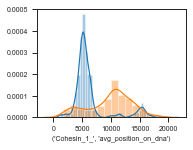

In [164]:
# where does cohesin accumulate in regard to MCM positions
sns.distplot(df[('MCM_1_','avg_position_on_dna')])
sns.distplot(df[('Cohesin_1_','avg_position_on_dna')])

In [165]:
# overview of barrier function calculated by 3 different methods
df2.groupby(['nacl','number_MCM']).describe().filter(regex='ARS1 passing probability')

molecule          ARS1 passing probability                                \
properties                                                                 
                                     count      mean       std       min   
nacl   number_MCM                                                          
150 mM 0.0                            75.0  0.372346  0.149733  0.000000   
       1.0                           236.0  0.067586  0.106459  0.000000   
500 mM 0.0                            40.0  0.553791  0.140458  0.089109   
       1.0                            64.0  0.225378  0.219409  0.000000   

molecule                                                   \
properties                                                  
                        25%       50%       75%       max   
nacl   number_MCM                                           
150 mM 0.0         0.285069  0.380952  0.486712  0.677966   
       1.0         0.000000  0.015994  0.092315  0.697674   
500 mM 0.0         0.528019  0.579339  0.627232  0.781955   
       1.0         0.009014  0.153816  0.417500  0.733945   

molecule          ARS1 passing probability ni            ...            \
properties                                               ...             
                                        count      mean  ...       75%   
nacl   number_MCM                                        ...             
150 mM 0.0                               75.0  0.375740  ...  0.486712   
       1.0                              236.0  0.080257  ...  0.116848   
500 mM 0.0                               40.0  0.553791  ...  0.627232   
       1.0                               64.0  0.229009  ...  0.417500   

molecule                    ARS1 passing probability dt                      \
properties                                                                    
                        max                       count      mean       std   
nacl   number_MCM                                                             
150 mM 0.0         0.677966                        74.0  0.368873  0.144935   
       1.0         0.697674                       151.0  0.087715  0.123547   
500 mM 0.0         0.781955                        40.0  0.574824  0.143864   
       1.0         0.733945                        62.0  0.220078  0.212391   

molecule                                                             
properties                                                           
                        min       25%       50%       75%       max  
nacl   number_MCM                                                    
150 mM 0.0         0.000000  0.286136  0.374743  0.481121  0.666667  
       1.0         0.000000  0.000000  0.020833  0.155934  0.697674  
500 mM 0.0         0.127072  0.563065  0.616200  0.656919  0.801527  
       1.0         0.000000  0.009642  0.194179  0.380114  0.733945  

[4 rows x 24 columns]

In [166]:
df2.head()

molecule               ARS1 block ARS1 block dt ARS1 block ni ARS1 pass  \
properties                                                                
2PFd8LrNDti9JB4QSh3mR9       56.0          50.0          56.0      30.0   
2QGskSzFLzrBr7YLN78knZ      100.0          80.0         100.0     148.0   
2Z4r51hJSvdkiVDjjqKUrj      112.0         112.0         112.0      56.0   
2sTgZedaFFf9CK5b3GF6Cn       13.0          14.0          13.0      24.0   
3AoBkpRczab2PADB4kryfY      153.0         132.0         153.0       4.0   

molecule               ARS1 pass dt ARS1 pass ni          Cohesin_1_  \
properties                                       avg_position_on_dna   
2PFd8LrNDti9JB4QSh3mR9         30.0         30.0        10644.210476   
2QGskSzFLzrBr7YLN78knZ        153.0        148.0        11142.190365   
2Z4r51hJSvdkiVDjjqKUrj         56.0         56.0         7348.886267   
2sTgZedaFFf9CK5b3GF6Cn         24.0         24.0        12755.246844   
3AoBkpRczab2PADB4kryfY          4.0          4.0        12054.104532   

molecule                                                            ...  \
properties             cum_pause_duration_(s)    d_coeff     dtime  ...   
2PFd8LrNDti9JB4QSh3mR9                    0.0  19.546419  0.187930  ...   
2QGskSzFLzrBr7YLN78knZ                    0.0  29.767491  0.182752  ...   
2Z4r51hJSvdkiVDjjqKUrj                    0.0  43.310971  0.183297  ...   
2sTgZedaFFf9CK5b3GF6Cn                    0.0  52.460617  0.184878  ...   
3AoBkpRczab2PADB4kryfY                    0.0  23.531469  0.184084  ...   

molecule               label_Cohesin   label_MCM    nacl nucleotide  \
properties                                                            
2PFd8LrNDti9JB4QSh3mR9    Halo-JF549  ybbR-LD655  500 mM        ATP   
2QGskSzFLzrBr7YLN78knZ    Halo-JF549  ybbR-LD655  500 mM        ATP   
2Z4r51hJSvdkiVDjjqKUrj    Halo-JF549  ybbR-LD655  500 mM        ATP   
2sTgZedaFFf9CK5b3GF6Cn    Halo-JF549  ybbR-LD655  500 mM        ATP   
3AoBkpRczab2PADB4kryfY    Halo-JF549  ybbR-LD655  500 mM        ATP   

molecule               number_Cohesin number_MCM               tags  \
properties                                                            
2PFd8LrNDti9JB4QSh3mR9            1.0        1.0           [accept]   
2QGskSzFLzrBr7YLN78knZ            1.0        0.0           [accept]   
2Z4r51hJSvdkiVDjjqKUrj            1.0        1.0           [accept]   
2sTgZedaFFf9CK5b3GF6Cn            1.0        0.0           [accept]   
3AoBkpRczab2PADB4kryfY            1.0        1.0  [accept, perfect]   

molecule               ARS1 passing probability ARS1 passing probability ni  \
properties                                                                    
2PFd8LrNDti9JB4QSh3mR9                 0.348837                    0.348837   
2QGskSzFLzrBr7YLN78knZ                 0.596774                    0.596774   
2Z4r51hJSvdkiVDjjqKUrj                 0.333333                    0.333333   
2sTgZedaFFf9CK5b3GF6Cn                 0.648649                    0.648649   
3AoBkpRczab2PADB4kryfY                 0.025478                    0.025478   

molecule               ARS1 passing probability dt  
properties                                          
2PFd8LrNDti9JB4QSh3mR9                    0.375000  
2QGskSzFLzrBr7YLN78knZ                    0.656652  
2Z4r51hJSvdkiVDjjqKUrj                    0.333333  
2sTgZedaFFf9CK5b3GF6Cn                    0.631579  
3AoBkpRczab2PADB4kryfY                    0.029412  

[5 rows x 43 columns]

## Figures

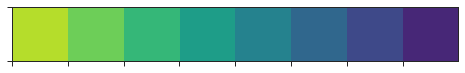

In [167]:
sns.palplot(palette)

### 1 - Cohesin diffusion coefficient (pause segments excluded)

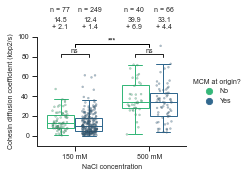

In [168]:
fig,axes = plt.subplots()

#setup style

boxprops = {'edgecolor': '.15', 'linewidth': 1, 'facecolor':'w'}
lineprops = {'color': '.15', 'linewidth': 1}
kwargs = {'hue_order': [False, True]}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75},
                      **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 2, 'alpha': 0.4},
                        **kwargs)

sns.boxplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='MCM_at_origin',data=df, ax=axes,
           order=['150 mM', '500 mM'], fliersize=0, palette=palette[2::3], **boxplot_kwargs)
sns.stripplot(x='nacl', y=('Cohesin_1_','d_coeff'), hue='MCM_at_origin',data=df, ax=axes,
           order=['150 mM', '500 mM'], dodge=True, jitter=0.2, palette=palette[2::3], **stripplot_kwargs)

axes.set_xlim(-0.5,1.5)
axes.set_ylim(-10,100)
axes.set_xlabel('NaCl concentration')
axes.set_ylabel('Cohesin diffusion coefficient (kbp2/s)')

#calculate number of observations
nobs = df.groupby(['nacl','number_MCM']).size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

# calculate mean and 95 % ci by bootstrapping (more accurate than 1.96xsem)

bootstrap_mean = []
bootstrap_95_ci_lower = []
bootstrap_95_ci_upper = []

for nacl in df['nacl'].sort_values().unique():
    for ori_mcm in df['MCM_at_origin'].sort_values().unique():       
        bootstrap_data = df[(df['nacl'] == nacl) & (df['MCM_at_origin']==ori_mcm)][('Cohesin_1_','d_coeff')]
        bootstrap_means = bootstrap(bootstrap_data,n_boot=10000)
        bootstrap_mean.append(np.mean(bootstrap_means))
        ci_lower, ci_upper = calc_ci(bootstrap_means,ci=95)
        bootstrap_95_ci_lower.append(ci_lower)
        bootstrap_95_ci_upper.append(ci_upper)

bootstrap_mean = [round(num,1) for num in bootstrap_mean]
ci_95_range = [(bootstrap_95_ci_upper[i] - bootstrap_95_ci_lower[i])/2 for i in range(len(bootstrap_95_ci_upper))]
ci_95_range = [round(num,1) for num in ci_95_range]

diffusion = [f'{bootstrap_mean[i]}\n+ {ci_95_range[i]}' for i in range(len(bootstrap_mean))]

#put nobs and diff values into plot

ind = 0
for tick in range(len(axes.get_xticklabels())):
    axes.text(tick-.2, 130, nobs[ind], horizontalalignment='center', verticalalignment='top', color='.15')
    axes.text(tick+.2, 130, nobs[ind+1], horizontalalignment='center', verticalalignment='top', color='.15')
    axes.text(tick-.2, 120, diffusion[ind], horizontalalignment='center', verticalalignment='top', color='.15')
    axes.text(tick+.2, 120, diffusion[ind+1], horizontalalignment='center', verticalalignment='top', color='.15')
    ind += 2

# alpha for boxplot filling (not required here)
for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
    
for i, artist in enumerate(axes.artists):
    if i % 2 == 0:
        col = palette[2]
    else:
        col = palette[5]

    # This sets the color for the main box
    artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = axes.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        
# Fix the legend, keep only the first two legend elements
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles[2:], ['No', 'Yes'], frameon=False, title='MCM at origin?',
               loc='center left', bbox_to_anchor=[1, 0.5],handletextpad=0.5)

lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]


# STATISTICS PART

# pairwise ttest +/-MCM
# test for equal variance and apply result to ttest
p_mcm = []

for nacl in df['nacl'].sort_values().unique():
    # equal variance?
    stats_lev, p_lev = scipy.stats.levene(df[(df['nacl'] == nacl) & (df['MCM_at_origin'] == False)][('Cohesin_1_','d_coeff')],
                                  df[(df['nacl'] == nacl) & (df['MCM_at_origin'] == True)][('Cohesin_1_','d_coeff')], center='median')
    
    stats, p = scipy.stats.ttest_ind(df[(df['nacl'] == nacl) & (df['MCM_at_origin'] == False)][('Cohesin_1_','d_coeff')],
                                     df[(df['nacl'] == nacl) & (df['MCM_at_origin'] == True)][('Cohesin_1_','d_coeff')], equal_var = p_lev>0.05)
    
    p_mcm.append(p)

# pairwise ttest c(nacl)
# test for equal variance and apply result to ttest

# equal variance?
stats_lev, p_lev = scipy.stats.levene(df[df['nacl'] == '150 mM'][('Cohesin_1_','d_coeff')],
                              df[df['nacl'] == '500 mM'][('Cohesin_1_','d_coeff')], center='median')

stats, p_nacl = scipy.stats.ttest_ind(df[df['nacl'] == '150 mM'][('Cohesin_1_','d_coeff')],
                                 df[df['nacl'] == '500 mM'][('Cohesin_1_','d_coeff')], equal_var = p_lev>0.05)

# draw   
ymax = axes.get_ylim()[-1]

x1, x2 = 0, 1   # columns 'ATP' and 'ATPgS' (first column: 0)
y, h, col = 0.90*ymax, 0.03*ymax, 'k'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
axes.text((x1+x2)*.5, y+h, significance(p_nacl), ha='center', va='bottom', color=col)

# boxplotter object to get exact x hue positions (what an overkill)
box_plotter = sns.categorical._BoxPlotter(x='nacl', y=('Cohesin_1_','d_coeff'), hue='MCM_at_origin', data=df,
                                order=['150 mM', '500 mM'], hue_order=None,
                                orient=None, width=0.75, color=None, palette=None, saturation=0.75,
                                dodge=True, fliersize=0, linewidth=None)

hue_offsets = box_plotter.hue_offsets
for i in range(2):
    x1, x2 = i+np.min(hue_offsets), i+np.max(hue_offsets)   # columns 'ATP' and 'ATPgS' (first column: 0)
    y, h, col = 0.80*ymax, 0.03*ymax, '.15'
    
    axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
    axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    # addtional ticks between min and max
    for offset in hue_offsets[1:-1]:
        axes.plot([x1, x1, 0+offset, 0+offset], [y, y+h, y+h, y], lw=1, c=col)

sns.despine()

plt.savefig(dir_out+'Cohesin_diffusion_coefficient.svg',transparent=True)

In [169]:
p_nacl

1.979983512205893e-20

In [170]:
p_mcm

[0.13176371688800206, 0.0938576671405093]

### 2 - MCM barrier for cohesin translocation

### a - 150 mM NaCl - including pause segments

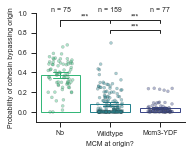

In [171]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom', color='.15')
    
# STATISTICS PART
# pairwise comparisons
p_mcm = []

# all combinations
for a,b in itertools.combinations(data['MCM_variant'].sort_values().unique(),2):
    
    #equal variance?
    stats_lev, p_lev = scipy.stats.levene(data[data['MCM_variant'] == a]['ARS1 passing probability'],
                                  data[data['MCM_variant'] == b]['ARS1 passing probability'], center='median')

    stats, p = scipy.stats.ttest_ind(data[data['MCM_variant'] == a]['ARS1 passing probability'],
                                     data[data['MCM_variant'] == b]['ARS1 passing probability'], equal_var = p_lev>0.05)
    p_mcm.append(p)
    
# draw   
ymax = axes.get_ylim()[-1]
x1, x2 = 0, 1

for i in range(len(p_mcm)):
    
    if (x1 == 0) and (x2 == 1):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif (x1 == 0) and (x2 == 2):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x2-1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif x1 == 1:
        y, h, col = 0.80*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    
    if ((i+2) < len(p_mcm)):
        x2+=1
    else:
        x1+=1
    
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_incl-pause.svg',transparent=True)

In [172]:
# check pair order
list(itertools.combinations(data['MCM_variant'].sort_values().unique(),2))

[('n/a', 'wt'), ('n/a', 'ydf'), ('wt', 'ydf')]

In [173]:
p_mcm

[1.061614097894474e-28, 1.2590700571505566e-32, 0.00029676530088128267]

In [174]:
nobs = data.groupby('MCM_variant').size()
nobs.index = nobs.index.str.lower()
nobs.sort_index(inplace=True)
nobs

MCM_variant
n/a     75
wt     159
ydf     77
dtype: int64

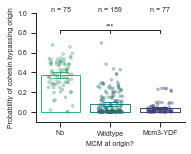

In [175]:
# Welch ANOVA and gameshowell posthoc
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom', color='.15')
    
# STATISTICS PART

# Welch ANOVA (unequal variances)

p = welch_anova(data=data, dv='ARS1 passing probability', between='MCM_variant')['p-unc'].item()

# draw   
ymax = axes.get_ylim()[-1]

x1, x2 = 0, data['MCM_variant'].nunique()-1
y, h, col = 0.80*ymax, 0.03*ymax, '.15'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
axes.text((x1+x2)*.5, y+h, significance(p), ha='center', va='bottom', color=col)
# addtional ticks between min and max
for offset in range(1,data['MCM_variant'].nunique()):
    axes.plot([x1, x1, x1+offset, x1+offset], [y, y+h, y+h, y], lw=1, c=col)
    

    
sns.despine()

#plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_incl-pause.svg',transparent=True)

In [176]:
welch_anova(data=data, dv='ARS1 passing probability', between='MCM_variant')

,Source,ddof1,ddof2,F,p-unc,np2
0,MCM_variant,2,164.238594,159.63573,3.102946e-39,0.560335


In [177]:
pairwise_gameshowell(data=data, dv='ARS1 passing probability', between='MCM_variant')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,n/a,wt,0.372346,0.081762,0.290584,0.019738,14.722223,120.493765,0.001,2.055627
1,n/a,ydf,0.372346,0.038312,0.334034,0.018660,17.901365,97.806831,0.001,2.889691
2,wt,ydf,0.081762,0.038312,0.043449,0.011828,3.673508,233.209902,0.001,0.508390


### b - 150 mM NaCl - excluding pause segments

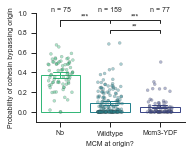

In [35]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability ni',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability ni',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom', color='.15')

# STATISTICS PART
# pairwise comparisons
p_mcm = []

# all combinations
for a,b in itertools.combinations(data['MCM_variant'].sort_values().unique(),2):
    
    #equal variance?
    stats_lev, p_lev = scipy.stats.levene(data[data['MCM_variant'] == a]['ARS1 passing probability ni'],
                                  data[data['MCM_variant'] == b]['ARS1 passing probability ni'], center='median')

    stats, p = scipy.stats.ttest_ind(data[data['MCM_variant'] == a]['ARS1 passing probability ni'],
                                     data[data['MCM_variant'] == b]['ARS1 passing probability ni'], equal_var = p_lev>0.05)
    p_mcm.append(p)
    
# draw   
ymax = axes.get_ylim()[-1]
x1, x2 = 0, 1

for i in range(len(p_mcm)):
    
    if (x1 == 0) and (x2 == 1):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif (x1 == 0) and (x2 == 2):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x2-1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif x1 == 1:
        y, h, col = 0.80*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    
    if ((i+2) < len(p_mcm)):
        x2+=1
    else:
        x1+=1

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_excl-pause.svg',transparent=True)

In [36]:
p_mcm

[1.257481448208193e-35, 9.745462121548526e-33, 0.006162306009238883]

### c - 500 mM NaCl - including pause segments (initial submission)

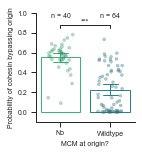

In [37]:
fig,axes = plt.subplots(figsize=(1.78,2))
nacl_conc = '500 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 1.5)
axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='.15')
    
# STATISTICS PART
# pairwise comparisons
p_mcm = []

# all combinations
for a,b in itertools.combinations(data['MCM_variant'].sort_values().unique(),2):
    
    #equal variance?
    stats_lev, p_lev = scipy.stats.levene(data[data['MCM_variant'] == a]['ARS1 passing probability'],
                                  data[data['MCM_variant'] == b]['ARS1 passing probability'], center='median')

    stats, p = scipy.stats.ttest_ind(data[data['MCM_variant'] == a]['ARS1 passing probability'],
                                     data[data['MCM_variant'] == b]['ARS1 passing probability'], equal_var = p_lev>0.05)
    p_mcm.append(p)
    
# draw   
ymax = axes.get_ylim()[-1]

for i in range(len(p_mcm)):
    x1, x2 = 0, i+1
    y, h, col = 0.85*ymax, 0.03*ymax, '.15'
    axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
    axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_500mM_incl-pause.svg',transparent=True)


### d - 500 mM NaCl - excluding pause segments

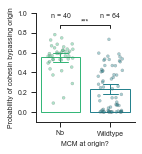

In [38]:
fig,axes = plt.subplots(figsize=(1.78,2))
nacl_conc = '500 mM'
data = df2[df2['nacl'] == nacl_conc]
           
barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability ni',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability ni',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 1.5)
axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='.15')

# STATISTICS PART
# pairwise comparisons
p_mcm = []

# all combinations
for a,b in itertools.combinations(data['MCM_variant'].sort_values().unique(),2):
    
    #equal variance?
    stats_lev, p_lev = scipy.stats.levene(data[data['MCM_variant'] == a]['ARS1 passing probability ni'],
                                  data[data['MCM_variant'] == b]['ARS1 passing probability ni'], center='median')

    stats, p = scipy.stats.ttest_ind(data[data['MCM_variant'] == a]['ARS1 passing probability ni'],
                                     data[data['MCM_variant'] == b]['ARS1 passing probability ni'], equal_var = p_lev>0.05)
    p_mcm.append(p)
    
# draw   
ymax = axes.get_ylim()[-1]

for i in range(len(p_mcm)):
    x1, x2 = 0, i+1
    y, h, col = 0.85*ymax, 0.03*ymax, '.15'
    axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
    axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    
sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_500mM_excl-pause.svg',transparent=True)

### e - 150 mM NaCl - excluding pause segments & dynamic threshold

### Check DNA length distribution

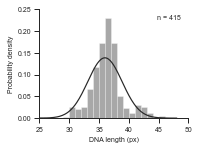

In [178]:
fig,axes = plt.subplots()

data = df2

sns.distplot(data['dna_length'], bins=np.linspace(25,50,26), kde=False, fit=norm, color='.15', norm_hist=True)

axes.set_xlim(25,50)
axes.set_ylim(0, 0.25)
axes.set_xlabel('DNA length (px)')
axes.set_ylabel('Probability density')
 
axes.text(0.95, 0.95, f"n = {len(data['dna_length'])}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

sns.despine()

plt.savefig(dir_out+'DNA_lengths.svg',transparent=True)

In [179]:
df2['dna_length'].mean()

35.98036259969445

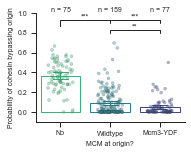

In [214]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[df2['nacl'] == nacl_conc]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_variant', y='ARS1 passing probability dt',data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

sns.stripplot(x='MCM_variant', y='ARS1 passing probability dt',data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[2::2], **stripplot_kwargs)

axes.set_xlim(-0.5, 2.5)
axes.set_ylim(-0.1,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom', color='.15')
    
# STATISTICS PART
# pairwise comparisons
p_mcm = []

# all combinations
for a,b in itertools.combinations(data['MCM_variant'].sort_values().unique(),2):
    
    #equal variance?
    stats_lev, p_lev = scipy.stats.levene(data[data['MCM_variant'] == a]['ARS1 passing probability dt'],
                                  data[data['MCM_variant'] == b]['ARS1 passing probability dt'], center='median')

    stats, p = scipy.stats.ttest_ind(data[data['MCM_variant'] == a]['ARS1 passing probability dt'],
                                     data[data['MCM_variant'] == b]['ARS1 passing probability dt'], equal_var = p_lev>0.05)
    p_mcm.append(p)
    
# draw   
ymax = axes.get_ylim()[-1]
x1, x2 = 0, 1

for i in range(len(p_mcm)):
    
    if (x1 == 0) and (x2 == 1):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif (x1 == 0) and (x2 == 2):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x2-1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif x1 == 1:
        y, h, col = 0.80*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    
    if ((i+2) < len(p_mcm)):
        x2+=1
    else:
        x1+=1

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_150mM_dynamic_thresh.svg',transparent=True)

In [215]:
p_mcm

[7.841790049370942e-35, 2.971820002231955e-32, 0.005687650146188176]

In [216]:
welch_anova(data=data, dv='ARS1 passing probability dt', between='MCM_variant')

,Source,ddof1,ddof2,F,p-unc,np2
0,MCM_variant,2,166.350899,137.158201,6.451475e-36,0.503388


In [217]:
pairwise_gameshowell(data=data, dv='ARS1 passing probability dt', between='MCM_variant')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,n/a,wt,0.367628,0.091801,0.275827,0.019581,14.086809,131.982616,0.001000,1.966906
1,n/a,ydf,0.367628,0.051981,0.315647,0.019376,16.290721,120.618801,0.001000,2.629696
2,wt,ydf,0.091801,0.051981,0.039820,0.014252,2.793903,210.737252,0.015632,0.386659


### 3 - MCM barrier for cohesin translocation vs #MCM(wt) (excl. pause segments)

### a - 150 mM NaCl

In [43]:
# equal variance?
scipy.stats.levene(data[data['MCM_bleaching_steps'] == 1]['ARS1 passing probability ni'],
                    data[data['MCM_bleaching_steps'] == 2]['ARS1 passing probability ni'],
                    data[data['MCM_bleaching_steps'] == 3]['ARS1 passing probability ni'],
                    data[data['MCM_bleaching_steps'] == 4]['ARS1 passing probability ni'], center='median')

LeveneResult(statistic=1.4343859861522634, pvalue=0.23346424272132887)

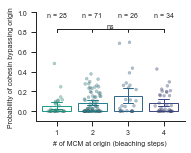

In [70]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'wt')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes,
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)

axes.set_ylim(-0.1,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(range(1,5))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='.15')
    
# STATISTICS PART

# Welch ANOVA (unequal variances)

p = welch_anova(data=data, dv='ARS1 passing probability ni', between='MCM_bleaching_steps')['p-unc'].item()

# draw   
ymax = axes.get_ylim()[-1]

x1, x2 = 0, data['MCM_bleaching_steps'].nunique()-1
y, h, col = 0.80*ymax, 0.03*ymax, '.15'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
axes.text((x1+x2)*.5, y+h, significance(p), ha='center', va='bottom', color=col)
# addtional ticks between min and max
for offset in range(1,data['MCM_bleaching_steps'].nunique()):
    axes.plot([x1, x1, x1+offset, x1+offset], [y, y+h, y+h, y], lw=1, c=col)

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_vs#MCM-wt_150mM.svg',transparent=True)

In [71]:
p

0.1720955399310821

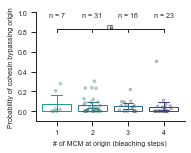

In [46]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'ydf')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes,
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)

axes.set_ylim(-0.1,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(range(1,5))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='.15')
    
# STATISTICS PART

# Welch ANOVA (unequal variances)

p = welch_anova(data=data, dv='ARS1 passing probability ni', between='MCM_bleaching_steps')['p-unc'].item()

# draw   
ymax = axes.get_ylim()[-1]

x1, x2 = 0, data['MCM_bleaching_steps'].nunique()-1
y, h, col = 0.80*ymax, 0.03*ymax, '.15'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
axes.text((x1+x2)*.5, y+h, significance(p), ha='center', va='bottom', color=col)
# addtional ticks between min and max
for offset in range(1,data['MCM_bleaching_steps'].nunique()):
    axes.plot([x1, x1, x1+offset, x1+offset], [y, y+h, y+h, y], lw=1, c=col)

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_vs#MCM-YDF_150mM.svg',transparent=True)

In [47]:
p

0.8495781061404268

### b - 500 mM NaCl

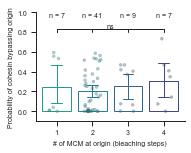

In [48]:
fig,axes = plt.subplots()
nacl_conc = '500 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'wt')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1, 'facecolor':(1, 1, 1, 0),
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

stripplot_kwargs = dict({'linewidth': 0.3, 'size': 3, 'alpha': 0.4},
                        **kwargs)

sns.barplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes,
            palette=palette[3::], **barplot_kwargs)

sns.stripplot(x='MCM_bleaching_steps', y='ARS1 passing probability ni', data=data, ax=axes,
           dodge=True, jitter=0.25, palette=palette[3::], **stripplot_kwargs)

axes.set_ylim(-0.1,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Probability of cohesin bypassing origin')
axes.set_xticklabels(range(1,5))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='.15')
    
# STATISTICS PART

# Welch ANOVA (unequal variances)

p = welch_anova(data=data, dv='ARS1 passing probability ni', between='MCM_bleaching_steps')['p-unc'].item()

# draw   
ymax = axes.get_ylim()[-1]

x1, x2 = 0, data['MCM_bleaching_steps'].nunique()-1
y, h, col = 0.80*ymax, 0.03*ymax, '.15'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
axes.text((x1+x2)*.5, y+h, significance(p), ha='center', va='bottom', color=col)
# addtional ticks between min and max
for offset in range(1,data['MCM_bleaching_steps'].nunique()):
    axes.plot([x1, x1, x1+offset, x1+offset], [y, y+h, y+h, y], lw=1, c=col)

sns.despine()

plt.savefig(dir_out+'Cohesin_origin_bypass_vs#MCM-wt_500mM.svg',transparent=True)

In [49]:
# can add a hue for MCM_variant (data with number_MCM > 0 only) later for comparison

### 4 - Pauses in cohesin translocation (150 mM data only)

### a - Global pause probability

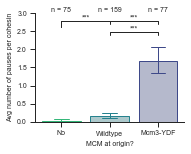

In [50]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc)]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1,
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

sns.barplot(x='MCM_variant', y=('Cohesin_1_','number_pauses'), data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

axes.set_ylim(0,3)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Avg number of pauses per cohesin')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 3, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom', color='.15')
    
# STATISTICS PART
# pairwise comparisons
p_mcm = []

# all combinations
for a,b in itertools.combinations(data['MCM_variant'].sort_values().unique(),2):
    
    #equal variance?
    stats_lev, p_lev = scipy.stats.levene(data[data['MCM_variant'] == a][('Cohesin_1_','number_pauses')],
                                  data[data['MCM_variant'] == b][('Cohesin_1_','number_pauses')], center='median')

    stats, p = scipy.stats.ttest_ind(data[data['MCM_variant'] == a][('Cohesin_1_','number_pauses')],
                                     data[data['MCM_variant'] == b][('Cohesin_1_','number_pauses')], equal_var = p_lev>0.05)
    p_mcm.append(p)
    
# draw   
ymax = axes.get_ylim()[-1]
x1, x2 = 0, 1

for i in range(len(p_mcm)):
    
    if (x1 == 0) and (x2 == 1):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif (x1 == 0) and (x2 == 2):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x2-1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif x1 == 1:
        y, h, col = 0.80*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    
    if ((i+2) < len(p_mcm)):
        x2+=1
    else:
        x1+=1
    
sns.despine()

plt.savefig(dir_out+'Cohesin_pause_probability_150mM.svg',transparent=True)


In [51]:
p_mcm

[0.000995744708835463, 3.70738614683651e-14, 1.4212797612471694e-12]

### b - Cohesin translocation: fraction idle

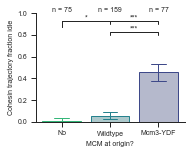

In [138]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc)]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1,
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

sns.barplot(x='MCM_variant', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

axes.set_ylim(0,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Cohesin trajectory fraction idle')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom', color='.15')
    
# STATISTICS PART
# pairwise comparisons
p_mcm = []

# all combinations
for a,b in itertools.combinations(data['MCM_variant'].sort_values().unique(),2):
    
    #equal variance?
    stats_lev, p_lev = scipy.stats.levene(data[data['MCM_variant'] == a][('Cohesin_1_','fraction_idle')],
                                  data[data['MCM_variant'] == b][('Cohesin_1_','fraction_idle')], center='median')

    stats, p = scipy.stats.ttest_ind(data[data['MCM_variant'] == a][('Cohesin_1_','fraction_idle')],
                                     data[data['MCM_variant'] == b][('Cohesin_1_','fraction_idle')], equal_var = p_lev>0.05)
    p_mcm.append(p)
    
# draw   
ymax = axes.get_ylim()[-1]
x1, x2 = 0, 1

for i in range(len(p_mcm)):
    
    if (x1 == 0) and (x2 == 1):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif (x1 == 0) and (x2 == 2):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x2-1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif x1 == 1:
        y, h, col = 0.80*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    
    if ((i+2) < len(p_mcm)):
        x2+=1
    else:
        x1+=1
    
sns.despine()

plt.savefig(dir_out+'Cohesin_trajectory_idle_150mM.svg',transparent=True)

In [139]:
p_mcm

[0.012052092279196135, 7.328638886759154e-17, 1.4822187992813065e-14]

In [ ]:
# Using Welch ANOVA and gameshowell posthoc
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc)]

barprops = {'edgecolor': palette[2::2], 'linewidth': 1,
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order': ['n/a', 'wt', 'ydf']}

barplot_kwargs = dict(barprops, **kwargs)

sns.barplot(x='MCM_variant', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

axes.set_ylim(0,1)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Cohesin trajectory fraction idle')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom', color='.15')
    
# STATISTICS PART
# pairwise comparisons
p_mcm = []

# all combinations
for a,b in itertools.combinations(data['MCM_variant'].sort_values().unique(),2):
    
    #equal variance?
    stats_lev, p_lev = scipy.stats.levene(data[data['MCM_variant'] == a][('Cohesin_1_','fraction_idle')],
                                  data[data['MCM_variant'] == b][('Cohesin_1_','fraction_idle')], center='median')

    stats, p = scipy.stats.ttest_ind(data[data['MCM_variant'] == a][('Cohesin_1_','fraction_idle')],
                                     data[data['MCM_variant'] == b][('Cohesin_1_','fraction_idle')], equal_var = p_lev>0.05)
    p_mcm.append(p)
    
# draw   
ymax = axes.get_ylim()[-1]
x1, x2 = 0, 1

for i in range(len(p_mcm)):
    
    if (x1 == 0) and (x2 == 1):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif (x1 == 0) and (x2 == 2):
        y, h, col = 0.90*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y-h, y+h, y+h, y], lw=1, c=col)
        axes.text((x2-1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    elif x1 == 1:
        y, h, col = 0.80*ymax, 0.03*ymax, '.15'
        axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
        axes.text((x1+x2)*.5, y+h, significance(p_mcm[i]), ha='center', va='bottom', color=col)
    
    if ((i+2) < len(p_mcm)):
        x2+=1
    else:
        x1+=1
    
sns.despine()

plt.savefig(dir_out+'Cohesin_trajectory_idle_150mM.svg',transparent=True)

In [131]:
data_welch = pd.concat([data['MCM_variant'], data[('Cohesin_1_', 'fraction_idle')]],axis=1)
data_welch.columns = ['MCM_variant', 'fraction_idle']
data_welch

,MCM_variant,fraction_idle
26g3CemDSKTjJiNz2xy5P,wt,0.760110
29gEBs7Ehu2fcjGcPSVW8q,n/a,0.000000
2EepcrQfakuKUFLrxzzFAQ,wt,0.562127
2chLcoDWzYU96Zd3bZK69n,wt,0.000000
2dGBGxYFmKsAkuimnTz7P4,wt,0.552862
...,...,...
uD2qeX3fcDrkHLrEykKP3x,n/a,0.000000
uwCQQd5mMKFh5gQwnP9b3p,n/a,0.000000
vbQbfgRcaVUyxLdweJ2Y7p,n/a,0.000000
xcfK4nJ1oobZtYbMGVJHYQ,n/a,0.000000


In [133]:
p = welch_anova(data= data_welch, dv='fraction_idle', between='MCM_variant')['p-unc'].item()
p

9.21592342735859e-19

In [136]:
from pingouin import pairwise_gameshowell, pairwise_ttests

In [135]:
pairwise_gameshowell(data= data_welch, dv='fraction_idle', between='MCM_variant')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,n/a,wt,0.010292,0.055696,-0.045404,0.017942,-2.530531,231.891317,0.032197,-0.353332
1,n/a,ydf,0.010292,0.454366,-0.444074,0.042656,-10.410669,85.352098,0.001000,-1.680521
2,wt,ydf,0.055696,0.454366,-0.398670,0.043927,-9.075768,95.636412,0.001000,-1.256029


In [137]:
pairwise_ttests(data= data_welch, dv='fraction_idle', between='MCM_variant')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,MCM_variant,n/a,wt,False,True,-2.530531,231.891317,two-sided,1.205209e-02,2.988,-0.281086
1,MCM_variant,n/a,ydf,False,True,-10.410669,85.352098,two-sided,7.328639e-17,1.893e+16,-1.660906
2,MCM_variant,wt,ydf,False,True,-9.075768,95.636412,two-sided,1.482219e-14,9.402e+13,-1.546335


### c - Cohesin translocation: fraction idle vs #MCM(wt)

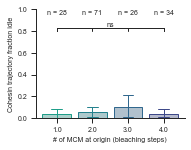

In [54]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'wt')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1,
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

sns.barplot(x='MCM_bleaching_steps', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes,
            palette=palette[3::], **barplot_kwargs)

axes.set_ylim(0,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Cohesin trajectory fraction idle')
#axes.set_xticklabels(range(1,5))

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='.15')
    
# STATISTICS PART

# Welch ANOVA (unequal variances)
# workaround because welch_anova cannot read multi-level dfs...
data_welch = pd.concat([data['MCM_bleaching_steps'], data[('Cohesin_1_', 'fraction_idle')]],axis=1)
# rename cols
data_welch.columns = ['MCM_bleaching_steps', 'fraction_idle']

p = welch_anova(data= data_welch, dv='fraction_idle', between='MCM_bleaching_steps')['p-unc'].item()

# draw   
ymax = axes.get_ylim()[-1]

x1, x2 = 0, data['MCM_bleaching_steps'].nunique()-1
y, h, col = 0.80*ymax, 0.03*ymax, '.15'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
axes.text((x1+x2)*.5, y+h, significance(p), ha='center', va='bottom', color=col)
# addtional ticks between min and max
for offset in range(1,data['MCM_bleaching_steps'].nunique()):
    axes.plot([x1, x1, x1+offset, x1+offset], [y, y+h, y+h, y], lw=1, c=col)
    
sns.despine()

plt.savefig(dir_out+'Cohesin_trajectory_idle_vs#MCM_150mM.svg',transparent=True)

In [55]:
p

0.6829952734487286

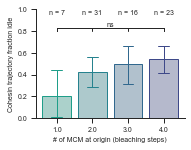

In [74]:
fig,axes = plt.subplots()
nacl_conc = '150 mM'
data = df2[(df2['nacl'] == nacl_conc) & (df2['MCM_variant'] == 'ydf')]

barprops = {'edgecolor': palette[3::], 'linewidth': 1,
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {}

barplot_kwargs = dict(barprops, **kwargs)

sns.barplot(x='MCM_bleaching_steps', y=('Cohesin_1_','fraction_idle'), data=data, ax=axes,
            palette=palette[3::], **barplot_kwargs)

axes.set_ylim(0,1)
axes.set_xlabel('# of MCM at origin (bleaching steps)')
axes.set_ylabel('Cohesin trajectory fraction idle')
#axes.set_xticklabels(range(1,5))

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_bleaching_steps').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 1, nobs[tick],
    horizontalalignment='center',verticalalignment='top', color='.15')
    
# STATISTICS PART

# Welch ANOVA (unequal variances)
# workaround because welch_anova cannot read multi-level dfs...
data_welch = pd.concat([data['MCM_bleaching_steps'], data[('Cohesin_1_', 'fraction_idle')]],axis=1)
# rename cols
data_welch.columns = ['MCM_bleaching_steps', 'fraction_idle']

p = welch_anova(data= data_welch, dv='fraction_idle', between='MCM_bleaching_steps')['p-unc'].item()

# draw   
ymax = axes.get_ylim()[-1]

x1, x2 = 0, data['MCM_bleaching_steps'].nunique()-1
y, h, col = 0.80*ymax, 0.03*ymax, '.15'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
axes.text((x1+x2)*.5, y+h, significance(p), ha='center', va='bottom', color=col)
# addtional ticks between min and max
for offset in range(1,data['MCM_bleaching_steps'].nunique()):
    axes.plot([x1, x1, x1+offset, x1+offset], [y, y+h, y+h, y], lw=1, c=col)
    
sns.despine()

plt.savefig(dir_out+'Cohesin_trajectory_idle_vs#MCM-YDF_150mM.svg',transparent=True)

In [75]:
p

0.1421750881292282

### d - Cohesin translocation: Pause durations

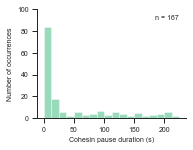

In [60]:
fig,axes = plt.subplots()

data = df_pause

sns.distplot(data['pause_duration'], bins=np.linspace(0,225,19), kde=False, color=palette[2], hist_kws={'alpha':0.5})

#axes.set_xlim(0,225)
axes.set_ylim(0, 100)
axes.set_xlabel('Cohesin pause duration (s)')
axes.set_ylabel('Number of occurrences')
 
axes.text(0.95, 0.95, f"n = {len(data['pause_duration'])}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

sns.despine()

plt.savefig(dir_out+'Cohesin_pause_durations.svg',transparent=True)

In [61]:
df_pause

,MCM_at_origin,MCM_bleaching_steps,MCM_position_on_dna,MCM_variant,nacl,pause_at_MCM,pause_duration,pause_position_on_dna
0,True,3.0,3536.266783,wt,500 mM,False,52.140,20173.783329
0,True,2.0,5107.475979,wt,500 mM,True,181.530,4840.273699
0,True,2.0,5273.016721,wt,150 mM,True,52.630,4932.590470
0,True,4.0,5049.834408,wt,150 mM,True,125.411,5164.722176
0,True,3.0,13035.814151,wt,150 mM,False,115.150,19359.930888
...,...,...,...,...,...,...,...,...
0,True,4.0,14695.084469,ydf,150 mM,True,5.890,14251.203653
0,True,4.0,14695.084469,ydf,150 mM,True,138.600,13940.304453
0,True,4.0,6610.954434,ydf,150 mM,True,5.010,5975.789453
0,True,4.0,6610.954434,ydf,150 mM,True,8.900,7631.180196


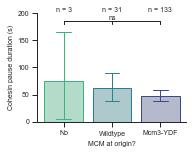

In [83]:
fig,axes = plt.subplots()

data = df_pause

barprops = {'edgecolor': palette[2::2], 'linewidth': 1,
            'errwidth':1, 'capsize':.3, 'n_boot':10000, 'seed': 42, 'ci':95, 'errcolor':'.15'}

kwargs = {'order':['n/a','wt','ydf']}

barplot_kwargs = dict(barprops, **kwargs)

sns.barplot(x='MCM_variant', y='pause_duration', data=data, ax=axes,
            palette=palette[2::2], **barplot_kwargs)

axes.set_ylim(0,200)
axes.set_xlabel('MCM at origin?')
axes.set_ylabel('Cohesin pause duration (s)')
axes.set_xticklabels(['No', 'Wildtype', 'Mcm3-YDF'])

# alpha for boxplot filling (not required here)
for patch in axes.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

# change errcolor
patches = axes.patches
lines_per_err = 3

for i, line in enumerate(axes.get_lines()):
    newcolor = patches[i // lines_per_err].get_edgecolor()
    line.set_color(newcolor)
    
#calculate nobs
nobs = data.groupby('MCM_variant').size()
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]
   
#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 200, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom', color='.15')
    
# STATISTICS PART

# Welch ANOVA (unequal variances)

p = welch_anova(data=data, dv='pause_duration', between='MCM_variant')['p-unc'].item()

# draw   
ymax = axes.get_ylim()[-1]

x1, x2 = 0, data['MCM_variant'].nunique()-1
y, h, col = 0.90*ymax, 0.03*ymax, '.15'
axes.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
axes.text((x1+x2)*.5, y+h, significance(p), ha='center', va='bottom', color=col)
# addtional ticks between min and max
for offset in range(1,data['MCM_variant'].nunique()):
    axes.plot([x1, x1, x1+offset, x1+offset], [y, y+h, y+h, y], lw=1, c=col)

sns.despine()

plt.savefig(dir_out+'Cohesin_pause_durations_hueMCM.svg',transparent=True)

In [84]:
p

0.5824128578066244

### e - Cohesin translocation: Pause position vs MCM position

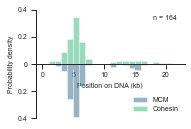

In [77]:
fig,axes = plt.subplots()

data = df_pause[df_pause['MCM_at_origin']]

sns.distplot(data['MCM_position_on_dna']/1000, bins=np.linspace(0,22,23), kde=False, norm_hist=True, 
             color=palette[5], label='MCM', hist_kws={'alpha':0.5})

for p in axes.patches:  # turn the histogram upside down
    p.set_height(-p.get_height())
for l in axes.lines:  # turn the kde curve upside down
    l.set_ydata(-l.get_ydata())

sns.distplot(data['pause_position_on_dna']/1000, bins=np.linspace(0,22,23), kde=False, norm_hist=True, 
             color=palette[2], label='Cohesin', hist_kws={'alpha':0.5})

#axes.set_xlim(0,225)
axes.set_ylim(-0.4, 0.4)
axes.set_xlabel('Position on DNA (kb)')
axes.set_ylabel('Probability density')
axes.legend(frameon=False, loc=4)
axes.set_yticks(np.arange(-0.4,0.5,0.2))
# pos_ticks = np.array([t for t in axes.get_yticks() if t > 0])
# ticks = np.concatenate([-pos_ticks[::-1], [0], pos_ticks])
# axes.set_yticks(ticks)
axes.set_yticklabels([0.4, 0.2, 0, 0.2, 0.4])
axes.spines['bottom'].set_position('zero')

axes.text(0.95, 0.95, f"n = {len(data['pause_duration'])}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

sns.despine()

plt.savefig(dir_out+'Cohesin_pause_positions.svg',transparent=True)

# QUESTIONS FOR KARL

Statistics:
- Tests: Welch t-test / Welch ANOVA for everything? although sometimes variances are equal, sample size is not. some suggest Welch as default
- for ttests I tested for equal variance so far and gave that as input
- 3 groups: should we do ANOVA and posthoc gameshowell?

Others:
- I added 1 encounter and 1 block for each pause now, independent of MCM colocalization (what would be the cutoff etc).
- reported blocking: pauses excluded, each pause calculated +1 block for now